# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2, use_multiprocessing = True)
print(dynamics.dt)


Finished loading process 50401
Finished loading process 50402
Finished loading process 50403
Finished loading process 50404
Finished loading process 50405
Finished loading process 50406
Finished loading process 50407
Finished loading process 50408
Finished loading process 50409
Finished loading process 50410
Finished loading process 50411
0.04
Finished loading process 50412
Finished loading process 50413
Finished loading process 50414
Finished loading process 50415
Finished loading process 50416


In [7]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 2.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [11]:
cost2 = FiniteDiffCost(lambda x, u, i: 2 * (x[0] ** 2) + 10 * (x[1] ** 2) + x[2] ** 2 + x[3] ** 2 + u[0] ** 2,
                      lambda x, i: 100 * (2 * (x[0] ** 2) + 10 * (x[1] ** 2) + x[2] ** 2 + x[3] ** 2),
                      4, 1, use_multiprocessing = True)

In [12]:
N = 100
x0 = np.array([0.0, np.pi - 1, 0.0, 0.0])
us_init = np.array([[-4.76751939e-01],
 [ 3.34490970e-01],
 [-3.99608551e-01],
 [ 8.41882163e-01],
 [-8.93302461e-01],
 [-3.57273055e-01],
 [-3.32158856e-01],
 [-4.82030121e-01],
 [-6.84388675e-01],
 [-4.26475287e-01],
 [-4.90913171e-01],
 [ 1.14754770e-01],
 [ 3.90275383e-01],
 [-4.36421243e-01],
 [ 5.57806778e-01],
 [ 7.83813923e-01],
 [-3.27778717e-01],
 [ 8.00582346e-01],
 [-8.49640982e-01],
 [-5.69222128e-01],
 [ 2.58447724e-01],
 [ 6.02857039e-01],
 [-6.11855326e-01],
 [ 7.00853348e-01],
 [-9.31090157e-01],
 [ 4.97665652e-01],
 [ 2.45721323e-01],
 [-1.92025996e-01],
 [ 2.72219728e-02],
 [ 7.95701514e-01],
 [-8.92320606e-01],
 [ 3.22802941e-02],
 [ 2.69562194e-01],
 [-1.46125346e-01],
 [-3.15934186e-02],
 [ 6.61809200e-01],
 [ 4.76622656e-01],
 [-9.78007260e-01],
 [ 5.73481914e-01],
 [-1.28208542e-02],
 [ 1.48147746e-01],
 [ 1.39421731e-04],
 [ 1.08812740e-01],
 [ 6.16007441e-01],
 [ 2.66982969e-01],
 [-2.09250070e-02],
 [ 6.04343953e-02],
 [ 4.14836049e-01],
 [-7.01346473e-01],
 [ 2.94563133e-01],
 [-3.07180590e-01],
 [ 6.53429823e-01],
 [ 3.87696411e-01],
 [-1.60361255e-01],
 [-7.91982930e-01],
 [ 3.04331662e-01],
 [-3.33057338e-01],
 [-1.45487867e-01],
 [-4.48293362e-01],
 [-4.56753222e-01],
 [-5.63113978e-02],
 [ 9.17106858e-01],
 [-7.79117478e-01],
 [-7.74944928e-01],
 [ 1.26081663e-01],
 [ 8.11397037e-02],
 [-6.58667412e-01],
 [ 9.01877119e-01],
 [-7.59017615e-01],
 [-6.54909707e-01],
 [-7.19152458e-01],
 [-8.23250291e-01],
 [-1.96576912e-01],
 [ 3.31076346e-01],
 [-9.59322994e-01],
 [ 6.61615691e-01],
 [-4.48940253e-01],
 [-4.10547311e-01],
 [-8.26340358e-01],
 [ 7.48939731e-01],
 [-8.83894866e-01],
 [ 4.12684469e-01],
 [-4.61578622e-01],
 [-8.29689676e-01],
 [-9.02561735e-01],
 [-2.44970624e-01],
 [ 2.86652487e-01],
 [-8.59512109e-01],
 [-5.89043961e-01],
 [ 6.21286175e-01],
 [-4.02464523e-01],
 [-7.80221770e-01],
 [-7.58513349e-01],
 [ 5.35469863e-01],
 [ 7.43535637e-01],
 [ 9.40814704e-01],
 [-9.31071558e-01],
 [-4.20465454e-01],
 [-1.28056017e-01],
 [-2.09487816e-01]])
#us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost2, N)

In [13]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 21002.37711588231 [-1.95745543  1.69610593 -0.53265088 -7.17418518]
iteration 1 accepted 18584.912064921606 [-1.94189518  2.40504485  0.76980115 -0.06023402]
iteration 2 accepted 15303.354604289012 [-1.90556542  1.39143036 -0.70739635 -2.5030591 ]
iteration 3 accepted 14721.57906765383 [-1.8980841   1.07327492 -0.73521374 -3.05588926]
iteration 4 accepted 14323.455819036779 [-0.6596236   1.21746112  0.87117461 -1.92857289]
iteration 5 accepted 13539.253774817997 [-0.76778268  1.04712148  0.86224701 -1.69171677]
iteration 6 accepted 13451.27316422305 [-0.89303793  0.73662515 -0.12139475 -2.04126333]
iteration 7 accepted 12815.551980478733 [-1.56381393  0.7233603  -0.04570314 -1.46884602]
iteration 8 accepted 12535.49564402782 [-0.6335261   0.91447549  0.25794252 -0.97367716]
iteration 9 accepted 12112.03680062346 [ 0.41593958  1.15125587  0.08447702 -0.38331834]
iteration 10 accepted 11931.077956131823 [-0.2966655   0.87372106 -0.10971332 -2.86589231]
iteration 11 a

iteration 93 accepted 7928.302331509314 [-0.45089385 -0.050776    0.30878883  0.14861336]
iteration 94 accepted 7922.493188827583 [-0.15749342 -0.04790061  0.34501785  0.22497941]
iteration 95 accepted 7896.6153680606785 [-0.12991881 -0.04781465  0.35331734  0.2160341 ]
iteration 96 accepted 7841.902637061639 [-0.25936289 -0.05226436  0.34651531  0.19756539]
iteration 97 accepted 7819.803530029081 [-0.34050735 -0.05500202  0.34376054  0.18959621]
iteration 98 accepted 7818.173393367252 [-0.57639002 -0.06295139  0.33679446  0.16841401]
iteration 99 accepted 7814.536639246672 [-0.54662805 -0.06093209  0.34026022  0.15049388]
iteration 100 accepted 7745.57817586952 [-0.45235585 -0.05814415  0.33764338  0.15336509]
iteration 101 accepted 7724.412145572187 [-0.40918163 -0.05938841  0.35279938  0.16350951]
iteration 102 accepted 7713.643859119406 [-0.4952948  -0.06296988  0.35702114  0.16515122]
iteration 103 accepted 7682.652277001324 [-0.38863086 -0.0557872   0.32933436  0.1527831 ]
iterat

iteration 186 accepted 5649.796898577014 [-0.00716493 -0.00894096  0.03901207  0.02081118]
iteration 187 accepted 5620.583330569498 [-0.08112763 -0.02054534  0.10148239  0.04998222]
iteration 188 accepted 5582.803600751687 [-0.0407026  -0.01393507  0.06593377  0.03345468]
iteration 189 accepted 5572.327047699982 [-0.0177988  -0.01005613  0.04533266  0.02378962]
iteration 190 accepted 5565.138295945056 [-0.1019243  -0.02357209  0.11732685  0.05814889]
iteration 191 accepted 5530.557716476757 [-0.12465836 -0.02702898  0.13710259  0.06564454]
iteration 192 accepted 5483.135093687335 [-0.09142667 -0.02142798  0.10786588  0.05059728]
iteration 193 accepted 5450.213478537584 [ 0.01138949 -0.0042911   0.01226013  0.01175601]
iteration 194 accepted 5433.828205482342 [ 0.00540158 -0.00555372  0.01958437  0.01398474]
iteration 195 accepted 5404.408510102969 [-0.08114227 -0.01981517  0.09625887  0.04938148]
iteration 196 accepted 5385.751617674518 [-0.01579023 -0.00858209  0.03583248  0.02213289]

iteration 277 accepted 3372.9418533968455 [-0.01730411 -0.00472294  0.02244154  0.01079448]
iteration 278 accepted 3348.358527245067 [-0.02449368 -0.00629637  0.03058705  0.01441652]
iteration 279 accepted 3345.4280247557426 [-0.02643995 -0.00680314  0.03318919  0.01543319]
iteration 280 accepted 3292.8315782925847 [-0.00382635 -0.00180502  0.00754952  0.00382027]
iteration 281 accepted 3267.1247979716236 [-0.01333091 -0.00389472  0.01828242  0.00868708]
iteration 282 accepted 3213.608215751848 [-0.00233056 -0.00140636  0.00571312  0.00286717]
iteration 283 accepted 3203.4497590696474 [ 0.00138152 -0.00054544  0.00141382  0.00086035]
iteration 284 accepted 3187.7511496502157 [-0.01772019 -0.00479445  0.02299633  0.01081992]
iteration 285 accepted 3151.2808940806044 [-0.02471169 -0.00633552  0.0308815   0.0144198 ]
iteration 286 accepted 3136.7972807404644 [-0.03311088 -0.00820617  0.04042129  0.01876617]
iteration 287 accepted 3108.8639798679305 [-0.01986933 -0.00524176  0.02530978  0.

In [11]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

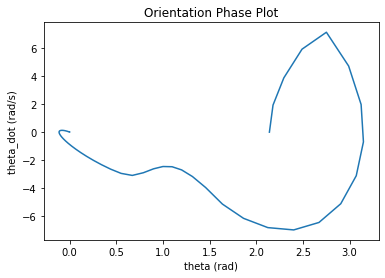

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

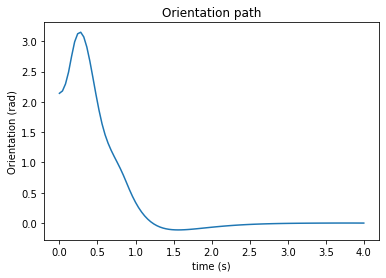

In [42]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

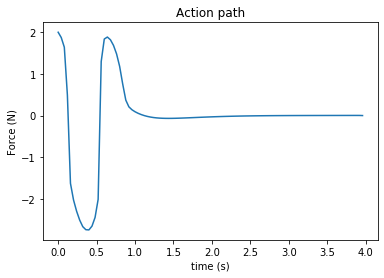

In [43]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

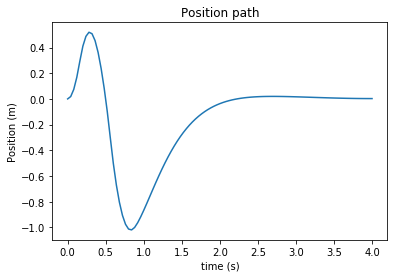

In [44]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

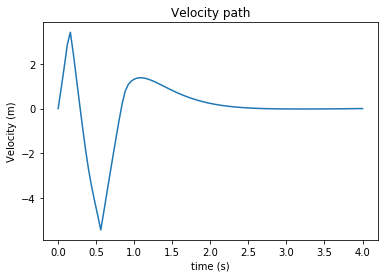

In [45]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

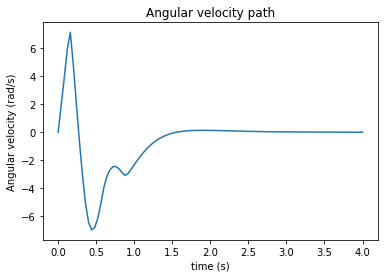

In [46]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

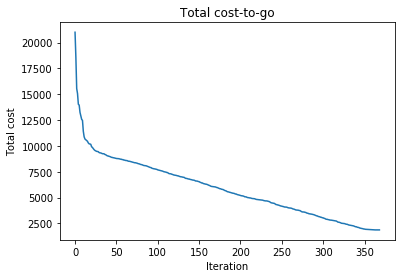

In [47]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [48]:
viewer = MjViewer(dynamics.sim)
dynamics.set_state(x0)
print(dynamics.get_state())
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    viewer.render()

Creating window glfw
[0.         2.14159265 0.         0.        ]
0 [1.9980842]
[0.01835764 2.18039918 0.92008372 1.93082176] [0.01835764 2.18039918 0.92008372 1.93082176]

1 [1.87088408]
[0.07388471 2.29608299 1.86542366 3.86896442] [0.07388471 2.29608299 1.86542366 3.86896442]

2 [1.63905907]
[0.16803653 2.4911347  2.85559211 5.91490111] [0.16803653 2.4911347  2.85559211 5.91490111]

3 [0.49041769]
[0.29357379 2.75228147 3.42053472 7.12149979] [0.29357379 2.75228147 3.42053472 7.12149979]

4 [-1.62831889]
[0.4111702  2.99061806 2.43835268 4.71346845] [0.4111702  2.99061806 2.43835268 4.71346845]

5 [-2.02777121]
[0.48693342 3.12431104 1.34768911 1.97065637] [0.48693342 3.12431104 1.34768911 1.97065637]

6 [-2.29710191]
[ 0.518831    3.14919475  0.25123576 -0.69180678] [ 0.518831    3.14919475  0.25123576 -0.69180678]

7 [-2.50944193]
[ 0.50728711  3.07213291 -0.82184481 -3.10654112] [ 0.50728711  3.07213291 -0.82184481 -3.10654112]

8 [-2.66651761]
[ 0.45378273  2.90613261 -1.839292

70 [-0.00327901]
[ 0.01862029 -0.00834497 -0.01117078  0.02664496] [ 0.01862029 -0.00834497 -0.01117078  0.02664496]

71 [-0.00279065]
[ 0.01813304 -0.00733472 -0.01321521  0.02410912] [ 0.01813304 -0.00733472 -0.01321521  0.02410912]

72 [-0.00235134]
[ 0.017571   -0.00642107 -0.01490884  0.02179322] [ 0.017571   -0.00642107 -0.01490884  0.02179322]

73 [-0.00195655]
[ 0.01694744 -0.00559547 -0.01628868  0.0196853 ] [ 0.01694744 -0.00559547 -0.01628868  0.0196853 ]

74 [-0.001602]
[ 0.01627427 -0.0048499  -0.01738801  0.01777308] [ 0.01627427 -0.0048499  -0.01738801  0.01777308]

75 [-0.00128367]
[ 0.0155621  -0.00417681 -0.01823665  0.01604407] [ 0.0155621  -0.00417681 -0.01823665  0.01604407]

76 [-0.00099779]
[ 0.01482044 -0.00356915 -0.01886116  0.01448568] [ 0.01482044 -0.00356915 -0.01886116  0.01448568]

77 [-0.00074081]
[ 0.01405778 -0.00302039 -0.01928506  0.01308522] [ 0.01405778 -0.00302039 -0.01928506  0.01308522]

78 [-0.00050945]
[ 0.01328174 -0.00252448 -0.01952905  0.0